In [2]:
import torch
import matplotlib.pyplot as plt
from mlrg.hmc import HMCSampler
from rgflow import RGLayer

### Phi4 Model Sampling

In [3]:
class Phi4Model(torch.nn.Module):
    ''' phi4 model energy 
        E = (1/2) sum_<ij> |x_i-x_j|^2 + (r/2) sum_i |x_i|^2 + (u/4) sum_i |x_i|^4
        
        Parameters:
            r :: real - (initial) value of r
            u :: real - (initial) value of u '''
    def __init__(self, r=0., u=1.):
        super().__init__()
        self.r = torch.nn.Parameter(torch.tensor(r))
        self.u = torch.nn.Parameter(torch.tensor(u))
        
    def extra_repr(self):
        return f'r={self.r.item()}, u={self.u.item()}'
        
    def clone(self):
        mdl = type(self)()
        mdl.load_state_dict(self.state_dict())
        return mdl
        
    def forward(self, x):
        energy = 0.
        for axis in range(2, x.dim()):
            dx2 = (x.roll(1,axis) - x).square().sum(1)
            energy = energy + dx2 / 2
        x2 = x.square().sum(1)
        energy = energy + self.r * x2 / 2 + self.u * x2.square() / 4
        energy = energy.view(energy.shape[:1]+(-1,)).sum(-1)
        return energy

In [3]:
class GaussianModel(torch.nn.Module):
    ''' phi4 model energy 
        E = (1/2) sum_<ij> |x_i-x_j|^2 + (r/2) sum_i |x_i|^2
        
        Parameters:
            r :: real - (initial) value of 
            '''
    def __init__(self, r=0.):
        super().__init__()
        self.r = torch.nn.Parameter(torch.tensor(r))
        
    def extra_repr(self):
        return f'r={self.r.item()}'
        
    def clone(self):
        mdl = type(self)()
        mdl.load_state_dict(self.state_dict())
        return mdl
        
    def forward(self, x):
        energy = 0.
        for axis in range(2, x.dim()):
            dx2 = (x.roll(1,axis) - x).square().sum(1)
            energy = energy + dx2 / 2
        x2 = x.square().sum(1)
        energy = energy + self.r * x2 / 2
        energy = energy.view(energy.shape[:1]+(-1,)).sum(-1)
        return energy

In [14]:
mdl = GaussianModel().requires_grad_(False)
for p in mdl.parameters():
    print(p)

Parameter containing:
tensor(0.)


In [5]:
hmc = HMCSampler(Phi4Model(r=-1.), [5,1,64,64])

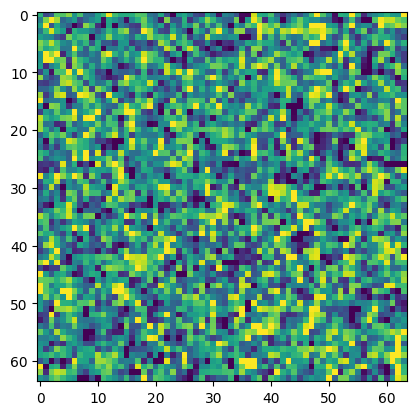

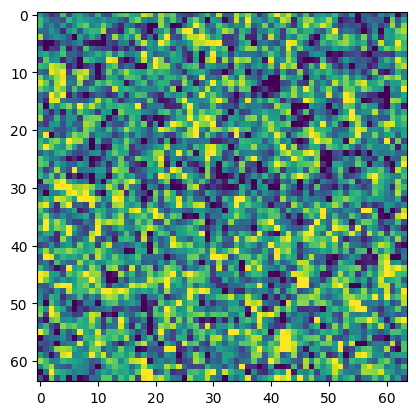

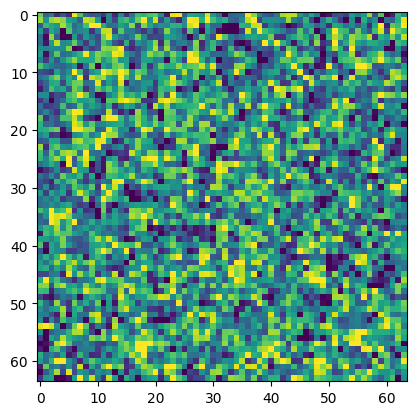

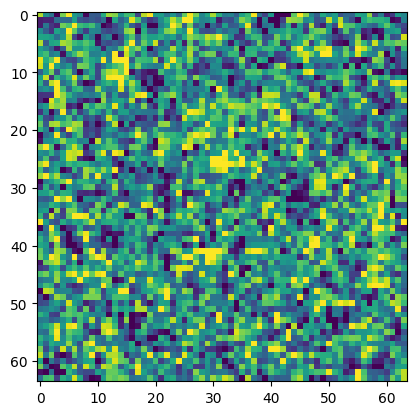

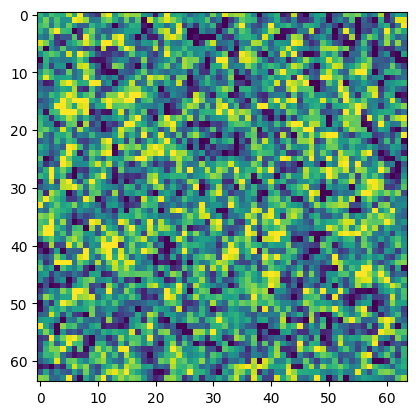

In [6]:
for x in hmc.sample():
    plt.figure()
    plt.imshow(x.squeeze(), vmin=-1, vmax=1)

### RG Layer Demo

In [6]:
hmc = HMCSampler(Phi4Model(r=-1.), [3,1,8,8])

In [7]:
rg = RGLayer([8, 8], 1)

In [8]:
x = hmc.sample()

In [9]:
y, z = rg.encode(x)

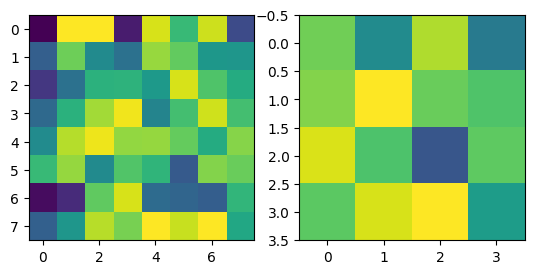

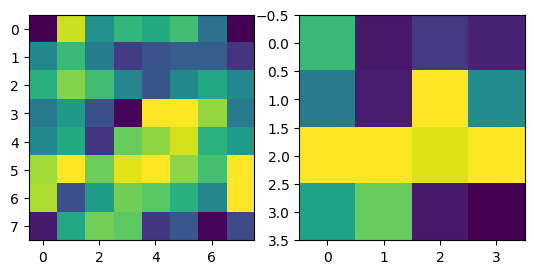

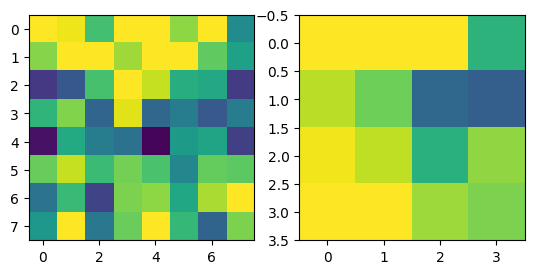

In [10]:
for x_, y_ in zip(x, y):
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.imshow(x_.detach().squeeze(), vmin=-1, vmax=1)
    ax2.imshow(y_.detach().squeeze(), vmin=-1, vmax=1)

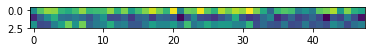

In [208]:
plt.imshow(z.detach().squeeze())

### RG Learner

In [23]:
class RGLearner(torch.nn.Module):
    def __init__(self, uv_model, uv_shape, dim, base_dist='Normal', **kwargs):
        super().__init__()
        self.uv_model = uv_model.requires_grad_(False)
        self.ir_model = uv_model.clone().requires_grad_(True)
        self.rglayer = RGLayer(uv_shape, dim, **kwargs)
        ir_shape = self.rglayer.partitioner.out_shape
        self.ir_sampler = HMCSampler(self.ir_model, (1, dim)+torch.Size(ir_shape))
        self.base_dist = getattr(torch.distributions, base_dist)(0., 1.)
        
    def sample(self, samples):
        with torch.no_grad():
            return self.rsample(samples)
            
    def rsample(self, samples):
        x_ir = self.ir_sampler.sample(samples=samples)
        z = self.base_dist.rsample(x_ir.shape[:2]+self.rglayer.partitioner.res_shape)
        x_uv, *_ = self.rglayer.decode(x_ir, z)
        return x_uv
        
    def loss(self, samples, lk=0.01, lg=0.01, mode=None, **kwargs):
        x_ir = self.ir_sampler.sample(samples=samples, **kwargs)
        z = self.base_dist.rsample(x_ir.shape[:2]+self.rglayer.partitioner.res_shape)
        x_uv, logJ, Ek, Eg = self.rglayer.decode(x_ir, z, mode='jf_reg', **kwargs)
        diff = self.uv_model(x_uv) - self.ir_model(x_ir) - logJ
        Loss = diff + lk * Ek + lg * Eg      # original Loss
        Loss_ = Loss.mean().detach()         # take average and detach
        Loss = (1 + self.ir_model(x_ir).detach() - self.ir_model(x_ir)) * (Loss-Loss_) # implement the reinforce algorithm. log(p(x_ir)) = -E(x_ir) + const
        Loss, diff, Ek, Eg = [val.mean() for val in (Loss, diff, Ek, Eg)]
        return Loss, diff, Ek, Eg

In [24]:
rgl = RGLearner(GaussianModel(r=3.), [8,8], 1, hdims=[8,8], hyper_dim=16)
optimizer = torch.optim.Adam(rgl.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

In [26]:
for i in range(1):
    for _ in range(100):
        optimizer.zero_grad()
        loss, *rest = rgl.loss(100)
        loss.backward()
        optimizer.step()
        print(f'{loss.item()} '+' '.join(f'{r.item()}' for r in rest))
        scheduler.step()

5.493163916980848e-05 2248.693115234375 803.3063354492188 460.68402099609375
1.602172778802924e-05 513.2874145507812 284.0288391113281 824.0300903320312
1.487731969973538e-05 193.8203582763672 180.55126953125 1167.46484375
-4.272460955689894e-06 191.00865173339844 168.13125610351562 1403.74365234375
-3.43322744811303e-06 193.26766967773438 182.85800170898438 1431.72900390625
6.179809588502394e-06 195.00579833984375 185.8648223876953 1327.93359375
-4.882812390860636e-06 193.69210815429688 193.37132263183594 1209.5714111328125
1.5106201317394152e-05 175.46798706054688 200.6548614501953 1237.4703369140625
1.144409225162235e-06 166.98214721679688 216.2401123046875 1397.90869140625
-7.324218586290954e-06 168.54820251464844 229.9402313232422 1611.8251953125
1.7089843822759576e-05 176.31883239746094 247.59751892089844 1782.1651611328125
-1.6269683328573592e-05 168.46231079101562 258.10955810546875 1579.6502685546875
-3.051757857974735e-06 162.8254852294922 249.83518981933594 1439.635986328125

In [27]:
rgl.ir_model

GaussianModel(r=3.0444905757904053)

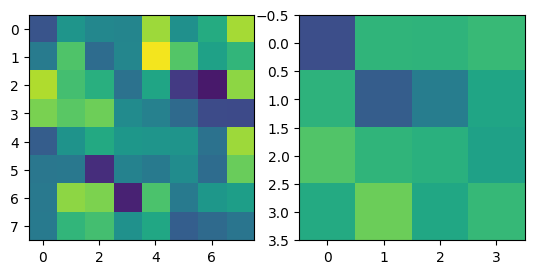

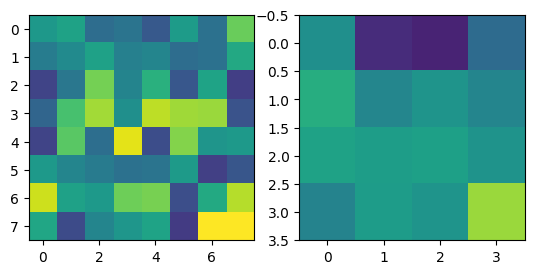

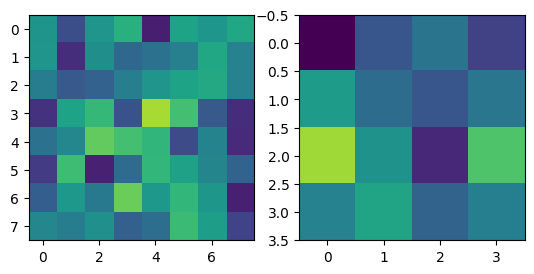

In [28]:
x = rgl.rsample(3)
y, z = rgl.rglayer.encode(x)
for x_, y_ in zip(x, y):
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.imshow(x_.detach().squeeze(), vmin=-1, vmax=1)
    ax2.imshow(y_.detach().squeeze(), vmin=-1, vmax=1)